# 순환 신경망 (RNN)
`작성자: 최원칠 강사`   
`traveler4d@gmail.com`   

순환 신경망은 시간에 대한 연속적인 순서가 있는 데이터에 유용한 신경망입니다.     
순환 신경망은 시간 스텝별로 하나의 셸(cell)을 두고 순차적으로 셸에서 연산된 가중치 결과를 전달합니다.   
따라서 각 셸은 이전 순서 셸의 특성 정보를 전달받기에 순서에 대한 영향력을 강조할 수 있게 됩니다.   

##### RNN 구조
<img src="src/20240113_142659.png" width="500" align="center"/>

## 1. RNN Cell
기본적으로 RNN Cell에는 히든상태(hidden state)와 입력데이터, 두개의 입력층이 존재합니다.  
가중치와 연산된 히든상태와 입력데이터는 합해져 tanh 활성화 함수가 적용되어 출력값이 됩니다.  
해당 출력값은 다음 셀의 히든상태으로 연결이 됩니다.  
<img src="src/20240113_165144.png" width="460" align="center"/>

#### keras SimpleRNN
keras의 레이어 모듈에는 SimpleRNN 와 SimpleRNNCell 레이어가 있습니다.   
- **SimpleRNNCell** : 하나의 셀만을 레이어로 구성
- **SimpleRNN** : 입력 형상의 timestep에 따라 여러개의 셀을 구성한 하나의 RNN 층

SimpleRNN 의 입력 형상은 다음과 같습니다.   

    (batch, timesteps, feature)
    
SimpleRNN 의 출력 형상은 return_sequences 인자 설정에 따라 다음과 같습니다.   

- **return_sequences = True** : 각 timesteps 에 해당하는 모든 셀의 결과를 반환   
    `(batch, timesteps, units)`   
    
- **return_sequences = False** : 가장 마지막 timesteps 에 해당하는 셀의 결과를 반환   
    `(batch, units)`


In [ ]:
## 코랩 사용시
from google.colab import drive
drive.mount('/content/drive')

import os
# 기존 경로 변경
os.chdir('/content/drive/MyDrive/dataset')

In [1]:
import tensorflow as tf
from tensorflow.data import Dataset
from tensorflow.keras import layers
import numpy as np
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:

def rnn_model(seq, input_size):

    rnn1 = layers.SimpleRNN(units = 16, return_sequences = True)
    rnn2 = layers.SimpleRNN(32, return_sequences = True , activation='relu')
    rnn3 = layers.SimpleRNN(16, return_sequences = False, activation='relu')

    dr = layers.Dropout(0.2)
    dense1 = layers.Dense(2)
    softmax = layers.Softmax()
    
    inp = tf.keras.Input((seq, input_size))
    x = rnn1(inp)
    x = layers.BatchNormalization()(x)
    x = rnn2(x)
    x = layers.BatchNormalization()(x)
    x = rnn3(x)
    x = layers.BatchNormalization()(x)
    x = dr(x)
    x = dense1(x)
    out = softmax(x)
    
    model = tf.keras.Model(inp, out, name = 'rnn_model')
    model.summary()
    return model


## 2. 시계열 데이터세트 학습

신체의 전기적 신호를 측정한 ecg데이터세트는 시간의 흐름이 있는 데이터 세트입니다.   
이렇게 시간의 순서적인 흐름이 있는데이터를 시계열 데이터라고 합니다.  

### 시계열 데이터 파라미터

- timestep(sampling_rate) : 하나의 시간단위 
- sequence length : 타임스텝의 개수(하나의 시퀀스 길이)
- sequence stride : 각 시퀀스별 간격 (시퀀스 외부 간격)

<img src="src/20240114_182219.png" width="460" align="center"/>


In [3]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('ecg.csv', header = None)
df

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4993,0.608558,-0.335651,-0.990948,-1.784153,-2.626145,-2.957065,-2.931897,-2.664816,-2.090137,-1.461841,...,1.757705,2.291923,2.704595,2.451519,2.017396,1.704358,1.688542,1.629593,1.342651,0.0
4994,-2.060402,-2.860116,-3.405074,-3.748719,-3.513561,-3.006545,-2.234850,-1.593270,-1.075279,-0.976047,...,1.388947,2.079675,2.433375,2.159484,1.819747,1.534767,1.696818,1.483832,1.047612,0.0
4995,-1.122969,-2.252925,-2.867628,-3.358605,-3.167849,-2.638360,-1.664162,-0.935655,-0.866953,-0.645363,...,-0.472419,-1.310147,-2.029521,-3.221294,-4.176790,-4.009720,-2.874136,-2.008369,-1.808334,0.0
4996,-0.547705,-1.889545,-2.839779,-3.457912,-3.929149,-3.966026,-3.492560,-2.695270,-1.849691,-1.374321,...,1.258419,1.907530,2.280888,1.895242,1.437702,1.193433,1.261335,1.150449,0.804932,0.0


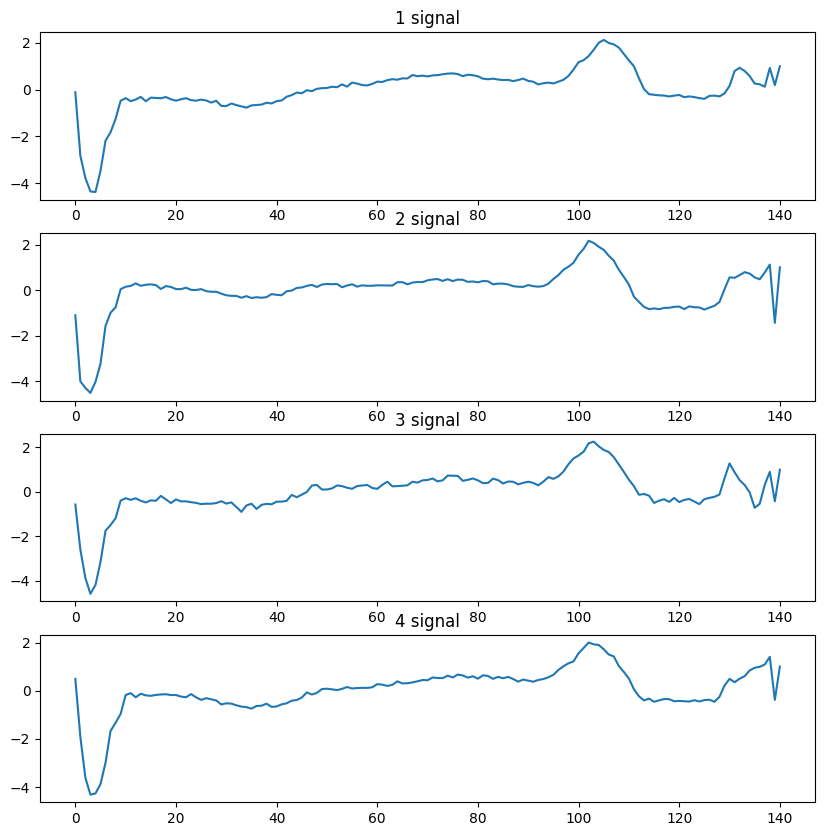

In [4]:
plt.figure(figsize=(10,10))

i = 0
for sig in df.iloc[:4].iloc:
    i += 1
    ax = plt.subplot(4,1,i)
    ax.plot(sig.index, sig)
    ax.set_title(f'{i} signal')
plt.show()

In [6]:
from sklearn.preprocessing import StandardScaler

X = df.iloc[:,:-1].to_numpy()
y = df.iloc[:,-1].to_numpy()

scaler = StandardScaler()
X = scaler.fit_transform(X)
X = np.reshape(X, (-1, 140,1))

ds = Dataset.from_tensor_slices((X,y))
train_ds, test_ds = tf.keras.utils.split_dataset(ds, 0.8, shuffle=True)
print(len(train_ds))
print(len(test_ds))

train_ds = train_ds.batch(32)
test_ds = test_ds.batch(32)
for x,y in test_ds.take(1):
    print(x.shape)
    print(y.shape)

3998
1000
(32, 140, 1)
(32,)


### 2.2 학습 및 평가하기

In [68]:
model = rnn_model(140, 1)

# 컴파일
opt = tf.keras.optimizers.Adam(learning_rate=0.0001) # 아담 최적경사하강법
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()        # mse 손실(회귀)
model.compile(optimizer=opt,
              loss=loss_fn,
              metrics=['accuracy'])

Model: "rnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 140, 1)]          0         
                                                                 
 simple_rnn_27 (SimpleRNN)   (None, 140, 16)           288       
                                                                 
 batch_normalization_27 (Bat  (None, 140, 16)          64        
 chNormalization)                                                
                                                                 
 simple_rnn_28 (SimpleRNN)   (None, 140, 32)           1568      
                                                                 
 batch_normalization_28 (Bat  (None, 140, 32)          128       
 chNormalization)                                                
                                                                 
 simple_rnn_29 (SimpleRNN)   (None, 16)                78

In [69]:
model.fit(train_ds, epochs=5, validation_data=test_ds)

Epoch 1/5
125/125 [==============================] - 31s 232ms/step - loss: 0.3778 - accuracy: 0.8362 - val_loss: 0.3533 - val_accuracy: 0.9260
Epoch 2/5
125/125 [==============================] - 32s 256ms/step - loss: 0.2263 - accuracy: 0.9235 - val_loss: 0.2322 - val_accuracy: 0.9440
Epoch 3/5
125/125 [==============================] - 34s 275ms/step - loss: 0.1951 - accuracy: 0.9387 - val_loss: 0.1566 - val_accuracy: 0.9510
Epoch 4/5
125/125 [==============================] - 35s 280ms/step - loss: 0.1716 - accuracy: 0.9442 - val_loss: 0.1205 - val_accuracy: 0.9570
Epoch 5/5
125/125 [==============================] - 35s 278ms/step - loss: 0.1503 - accuracy: 0.9530 - val_loss: 0.1002 - val_accuracy: 0.9610


## 3. Lstm Cell
RNN은 학습 중 경사하강법의 기울기가 0에 가까워지는 기울기 소실(Vanishing Gradient Descen) 문제가 생깁니다.   
0 기울기로 가중치를 곱하면 네트워크가 새로운 가중치를 학습하지 못하고 고정이 됩니다.   
이러한 문제는 더 긴 시퀀스(타입스텝)과 레이어가 많을수록 증가하며, 더 앞쪽의 시간 순서의 정보(더 먼 과거) 의 정보를 잃어버리는 문제가 됩니다.  

### LSTM 구조
lstm cell은 rnn의 기울기 소실 문제를 완화 하기 위해 히든상태과 입력데이터 외에 cell상태(cell state)를 추가로 사용합니다.   
cell 상태는 이전 lstm cell 들의 정보를 보관하며 이동하는 층이기에 기본 rnn 보다 장기적인 정보기억이 가능합니다.   
<img src="src/20240114_165055.png" width="460" align="center"/>

lstm cell은 3개의 시그모이드 함수를 이용하여 3개의 게이트를 만들어 정보의 흐름을 만듭니다.  
- 망각 게이트 : 셀 상태의 기존 장기 기억 정보를 얼마나 저장할 것인지를 결정. 
- 입력 게이트 : 셀 상태에 어떤 정보를 추가할지 결정.
- 출력 게이트 : 셀 상태의 어느 부분이 출력을 생성하는지 결정.

In [7]:
def lstm_model(input_size):
    
    lstm1 = layers.LSTM(units = 16, return_sequences = True)
    lstm2 = layers.LSTM(32, return_sequences = True)
    lstm3 = layers.LSTM(16, return_sequences = True)
    dr = layers.Dropout(0.2)
    gap = layers.GlobalAveragePooling1D()
    dense1 = layers.Dense(2)
    softmax = layers.Softmax()
    
    inp = tf.keras.Input(input_size)
    x = lstm1(inp)
    x = layers.BatchNormalization()(x)
    x = lstm2(x)
    x = layers.BatchNormalization()(x)
    x = lstm3(x)
    x = layers.BatchNormalization()(x)
    x = dr(x)
    x = gap(x)
    x = dense1(x)
    out = softmax(x)
    return tf.keras.Model(inp, out, name = 'lstm_model')


In [8]:
model = lstm_model((140,1))
model.summary()
# 컴파일
opt = tf.keras.optimizers.Adam(learning_rate=0.001) # 아담 최적경사하강법
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()     
model.compile(optimizer=opt,
              loss=loss_fn,
              metrics=['accuracy'])

Model: "lstm_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 140, 1)]          0         
                                                                 
 lstm (LSTM)                 (None, 140, 16)           1152      
                                                                 
 batch_normalization (BatchN  (None, 140, 16)          64        
 ormalization)                                                   
                                                                 
 lstm_1 (LSTM)               (None, 140, 32)           6272      
                                                                 
 batch_normalization_1 (Batc  (None, 140, 32)          128       
 hNormalization)                                                 
                                                                 
 lstm_2 (LSTM)               (None, 140, 16)           3

In [9]:
model.fit(train_ds, epochs=5, validation_data=test_ds)

Epoch 1/5
125/125 [==============================] - 30s 63ms/step - loss: 0.3716 - accuracy: 0.8782 - val_loss: 0.5988 - val_accuracy: 0.5970
Epoch 2/5
125/125 [==============================] - 5s 39ms/step - loss: 0.1520 - accuracy: 0.9575 - val_loss: 0.4857 - val_accuracy: 0.8280
Epoch 3/5
125/125 [==============================] - 4s 32ms/step - loss: 0.0980 - accuracy: 0.9702 - val_loss: 0.2147 - val_accuracy: 0.9280
Epoch 4/5
125/125 [==============================] - 4s 33ms/step - loss: 0.0837 - accuracy: 0.9737 - val_loss: 0.0920 - val_accuracy: 0.9690
Epoch 5/5
125/125 [==============================] - 4s 31ms/step - loss: 0.0719 - accuracy: 0.9760 - val_loss: 0.1346 - val_accuracy: 0.9460
